# Part 3-Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

In [970]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import json
import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

Convert Json File into Pandas DF

In [971]:
time_format = '%Y-%m-%d'

openfile=open('/Users/asifbala/Local-SpringBoard/ultimate_challenge/ultimate_data_challenge.json')

jsondata=json.load(openfile)

df=pd.DataFrame(jsondata)

openfile.close()

In [972]:
print(df.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False

In [973]:
print(df.shape)

(50000, 12)


In [974]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


In [975]:
print(df.describe())

           avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000           

Fill in missing values(for avg_rating_by_driver and avg_rating_of_driver)

In [976]:
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


Create Active Target Variable

'1' is active and '0' is not active.

In [977]:
df['signup_date'] = pd.to_datetime(df['signup_date'], format=time_format)

df['six_months'] = df['signup_date'] + datetime.timedelta(days=181)

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'], format=time_format)

df['diff'] = list(df['six_months'] - df['last_trip_date'])

df['diff'] = df['diff'].dt.days

df['active'] = np.where(df['diff'] <= 30,1,0)

print(df.shape)

(50000, 15)


Fix Class Imbalance

In [978]:
#Find Number of samples which are active
no_active = len(df[df['active'] == 1])
no_non_active = len(df[df['active'] == 0])

print(no_active)
print(no_non_active)

#Get indices of non active samples
non_active_indices = df[df.active == 0].index

#Random sample non active indices
random_indices = np.random.choice(non_active_indices,no_active, replace=False)

#Find the indices of active samples
active_indices = df[df.active == 1].index

#Concat active indices with sample non-active ones
under_sample_indices = np.concatenate([active_indices,random_indices])

#Get Balanced Dataframe
under_sample = df.loc[under_sample_indices]

print(under_sample.shape)

12198
37802
(24396, 15)


# Visual Exploratory Data Analysis

Perform feature to target exploratory data analysis. I will plot and analyze the various inputs to derive any key features that show a large difference between active non active users. I will then leverage those key features for my predictive model. 

1    12198
0    12198
Name: active, dtype: int64


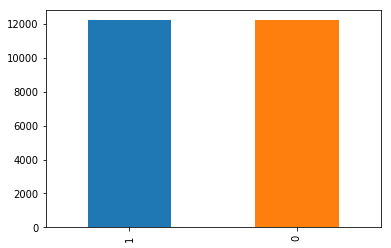

In [979]:
class_counts = under_sample['active'].value_counts()

print(class_counts)

class_counts.plot(kind='bar')

plt.show()

active     0  1
avg_dist       
0.00      46  6
0.01      13  2
0.02       4  1
0.03       2  0
0.04       2  0


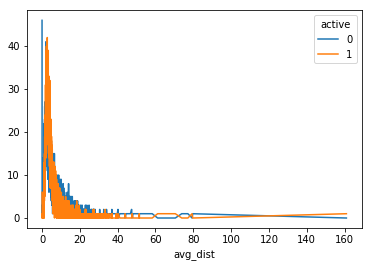

In [980]:
avg_dist_active = pd.crosstab(under_sample['avg_dist'], under_sample['active'])

print(avg_dist_active.head())

avg_dist_active.plot()

plt.show()

active                 0   1
avg_rating_by_driver        
1.0                   62  12
1.5                    2   0
2.0                   38   6
2.3                    1   0
2.5                    6   0


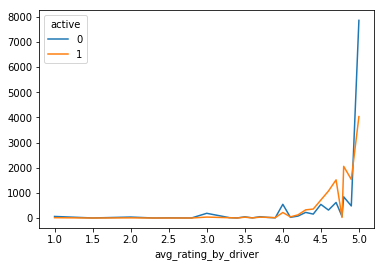

In [981]:
avg_rating_by_driver_active = pd.crosstab(under_sample['avg_rating_by_driver'],under_sample['active'])

print(avg_rating_by_driver_active.head())

avg_rating_by_driver_active.plot()

plt.show()

active                 0   1
avg_rating_of_driver        
1.0                   77  22
1.5                    2   0
1.6                    0   1
1.9                    1   0
2.0                   62  22


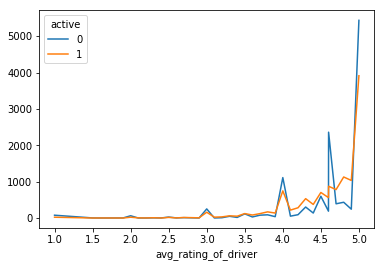

In [982]:
avg_rating_of_driver_active = pd.crosstab(under_sample['avg_rating_of_driver'],under_sample['active'])

print(avg_rating_of_driver_active.head())

avg_rating_of_driver_active.plot()

plt.show()

active        0     1
avg_surge            
1.00       9260  5747
1.01         60   297
1.02        107   509
1.03         84   368
1.04        111   413


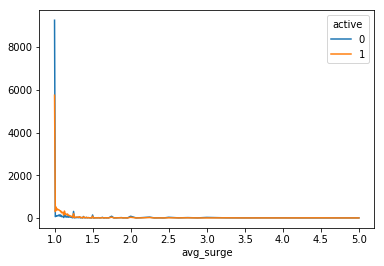

In [983]:
avg_surge_active = pd.crosstab(under_sample['avg_surge'],under_sample['active'])

print(avg_surge_active.head())

avg_surge_active.plot()

plt.show()

active                 0         1
city                              
Astapor         0.626800  0.373200
King's Landing  0.325694  0.674306
Winterfell      0.511256  0.488744


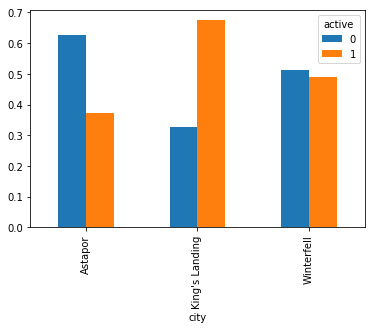

In [984]:
city_active = pd.crosstab(under_sample['city'],under_sample['active'],normalize='index')

print(city_active.head())

city_active.plot(kind='bar')

plt.show()

active        0     1
surge_pct            
0.0        9255  5718
0.4           0     1
0.5           0     3
0.6           0     1
0.7           0     5


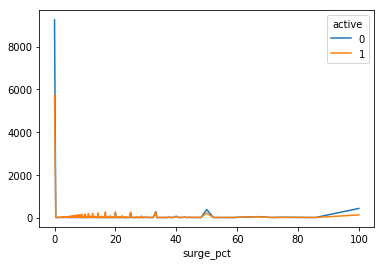

In [985]:
surge_pct_active = pd.crosstab(under_sample['surge_pct'],under_sample['active'])

print(surge_pct_active.head())

surge_pct_active.plot()

plt.show()

active                     0     1
trips_in_first_30_days            
0                       3915  3381
1                       3901  2001
2                       1810  1728
3                        873  1067
4                        552   864


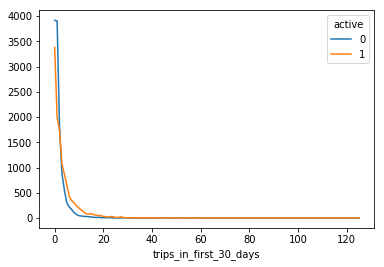

In [986]:
trips_in_first_30_days_active = pd.crosstab(under_sample['trips_in_first_30_days'],under_sample['active'])

print(trips_in_first_30_days_active.head())

trips_in_first_30_days_active.plot()

plt.show()

active                  0     1
ultimate_black_user            
False                8113  5942
True                 4085  6256


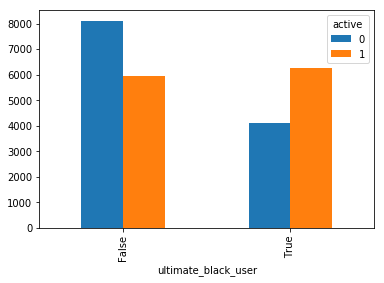

In [987]:
ultimate_black_user_active = pd.crosstab(under_sample['ultimate_black_user'],under_sample['active'])

print(ultimate_black_user_active.head())

ultimate_black_user_active.plot(kind='bar')

plt.show()

In [988]:
weekday_pct_active = pd.crosstab(under_sample['weekday_pct'],under_sample['active'])

print(weekday_pct_active.head())

active          0    1
weekday_pct           
0.0          2663  873
4.0             0    1
5.0             0    1
6.3             1    2
6.7             1    1


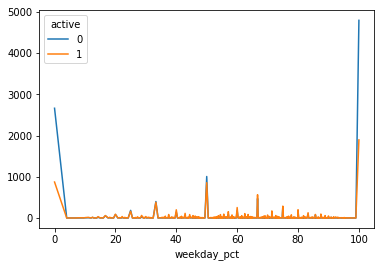

In [989]:
weekday_pct_active.plot()

plt.show()

# Feature Engineering

Derived features:

-Number of drivers with 100 weekday pct

-number of drivers with 0 weekday pct

-number of drivers with average distance of 0 in first 30 days

-true or false ultimate_black_user

-number of 0 surge percentage

-city signed up in was Kings Landing or not

-city signed up in was Astapor or not

-number of avg_surge being 1

-number of avg_rating_of_driver being 5

-number of avg_rating_by_driver being 5

Create Features DF that will be input into model

In [990]:
under_sample['weekday_pct_100'] = np.where(under_sample['weekday_pct'] == 100,1,0)

under_sample['weekday_pct_0'] = np.where(under_sample['weekday_pct'] == 0,1,0)

under_sample['avg_dist_0'] = np.where(under_sample['avg_dist'] == 0,1,0)

under_sample = pd.get_dummies(under_sample, prefix='one_hot', columns=['ultimate_black_user'])

under_sample['surge_pct_0'] = np.where(under_sample['surge_pct'] == 0,1,0)

under_sample['avg_surge_1'] = np.where(under_sample['avg_surge'] == 1,1,0)

under_sample['avg_rating_of_driver_5'] = np.where(under_sample['avg_rating_of_driver'] == 5,1,0)

under_sample['avg_rating_by_driver_5'] = np.where(under_sample['avg_rating_by_driver'] == 5,1,0)

under_sample = pd.get_dummies(under_sample, prefix='one_hot', columns=['city'])

feature_df = under_sample[['avg_dist_0','weekday_pct_100','weekday_pct_0','surge_pct_0','avg_surge_1','avg_rating_of_driver_5','avg_rating_by_driver_5','one_hot_Astapor','one_hot_King\'s Landing','one_hot_True','one_hot_False','active']]

print(feature_df.head())

    avg_dist_0  weekday_pct_100  weekday_pct_0  surge_pct_0  avg_surge_1  \
3            0                0              0            0            0   
16           0                0              0            1            1   
17           0                0              0            1            1   
19           0                0              0            0            0   
32           0                1              0            0            0   

    avg_rating_of_driver_5  avg_rating_by_driver_5  one_hot_Astapor  \
3                        0                       0                0   
16                       1                       0                0   
17                       0                       0                0   
19                       1                       1                0   
32                       0                       1                0   

    one_hot_King's Landing  one_hot_True  one_hot_False  active  
3                        1             1          

# Model

In [991]:
x = feature_df.drop('active',axis=1)

y = feature_df['active']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=21,stratify=y)

print(y_train.value_counts())

print(y_test.value_counts())

0    8539
1    8538
Name: active, dtype: int64
1    3660
0    3659
Name: active, dtype: int64


In [992]:
xgb = XGBClassifier(max_depth=3,n_estimators=250,learning_rate=0.1)

cv_scores_xgb = cross_val_score(xgb,x,y,cv=5)

print(cv_scores_xgb)

mean_cv_scores_xgb = np.mean(cv_scores_xgb)

print(mean_cv_scores_xgb)

[0.72397541 0.72233607 0.73012295 0.73185732 0.73349733]
0.7283578159552088


In [993]:
xgb = xgb.fit(x_train,y_train)

y_pred_xgb = xgb.predict(x_test)

print(y_pred_xgb)

[1 1 1 ... 0 0 1]


In [994]:
y_pred_proba_xgb = xgb.predict_proba(x_test)

print(y_pred_proba_xgb)

[[0.18461353 0.8153865 ]
 [0.22032088 0.7796791 ]
 [0.4058841  0.5941159 ]
 ...
 [0.5897088  0.4102912 ]
 [0.7331958  0.2668042 ]
 [0.41716677 0.58283323]]


In [995]:
y_pred_proba_xgb_df = pd.DataFrame(y_pred_proba_xgb)

print(y_pred_proba_xgb_df.head())

          0         1
0  0.184614  0.815386
1  0.220321  0.779679
2  0.405884  0.594116
3  0.124455  0.875545
4  0.516211  0.483789


In [996]:
cr_xgb = classification_report(y_test,y_pred_xgb)

print(cr_xgb)

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      3659
           1       0.72      0.75      0.73      3660

   micro avg       0.73      0.73      0.73      7319
   macro avg       0.73      0.73      0.73      7319
weighted avg       0.73      0.73      0.73      7319



In [997]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = xgb.feature_importances_
feature_importance = feature_importance.set_index(x.columns)
feature_importance['coef'].nlargest(10)

avg_rating_by_driver_5    0.146881
one_hot_King's Landing    0.142186
avg_dist_0                0.120054
avg_rating_of_driver_5    0.109993
one_hot_True              0.094567
weekday_pct_0             0.091214
one_hot_Astapor           0.083166
weekday_pct_100           0.077800
surge_pct_0               0.075117
avg_surge_1               0.059021
Name: coef, dtype: float32

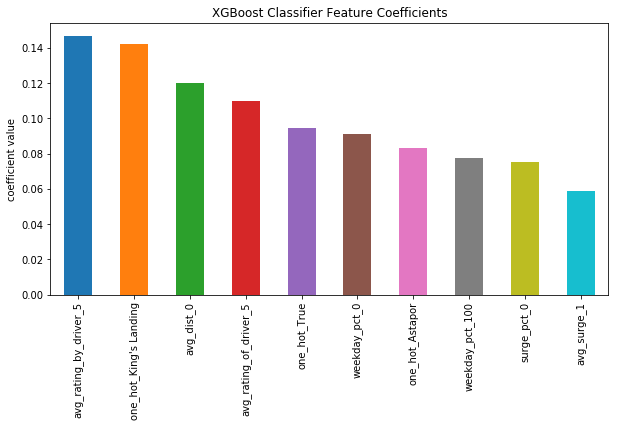

In [998]:
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('XGBoost Classifier Feature Coefficients')
plt.ylabel('coefficient value')
plt.show()

I used the extreme gradient boosting classifier as my machine learning model. With the features highlighted in the graph, I generated an accuracy of 73 percent on whether or not a user will be 'active' within their sixth month in the system.

The top two key indicators of performance that stood out above the rest was whether the rider’s average rating over all of their trips by driver was a 5 or not and whether the user signed up in the city of King's Landing. These gave the largest coefficient values indicating the highest feature importances by the XGBoost model. These model coefficients will indicate what to focus on.

It would appear how the drivers trips are being rated by the riders(being given a rating of 5 or not) seems to have the most impact on whether or not they will remain active in their sixth month. Perhaps changes could be made that would make it easier/more likely for riders to give 5 star ratings.  Also, it appears people who signed up in King's Landing were the most likely to remain active. For this, I would recommend that Ultimate focus highly on improving aspects of the product that would most appeal to residents of King's Landing.

It is important to note that the non-active samples in the original df is being undersampled from 37k to 12k, so which samples exactly are being undersampled will change from run to run, which could change the feature importances.